## CTC-BARQ x 375 Pilot Study v1
#### Alex Eyre (2025)

____
### Import Packages

In [40]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# Imputation Tools
from fancyimpute import IterativeSVD

# Clustering Tools Requiring Imputation
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Clustering Tools Handling Missing Data
from ppca import PPCA

In [41]:
# Additional Options
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('bmh')

____
### Define Functions

In [42]:
def histplots(data, idx_list, ax_idx):
    bins_list = [-0.5,0.5,1.5,2.5,3.5,4.5]
    i         = 0     
    nrow      = 0
    ncol      = 0
    
    while nrow < len(ax_idx):
        ncol = 0
        while ncol < len(ax_idx[0]):
            if i == len(data.columns):
                break
            
            ax_idx[nrow, ncol].hist(data.iloc[:,i].dropna(),
                                    density = True,
                                    bins    = bins_list,
                                    range   = (1,6),
                                    alpha   = 0.6,
                                    edgecolor = 'black')
            ax_idx[nrow, ncol].set_title(idx_list[i])
            ax_idx[nrow, ncol].set_xticks(range(0,5))
            ncol = ncol + 1
            i = i + 1    
        nrow = nrow + 1

____
### Data Upload

In [43]:
ctc              = pd.read_excel("Data/CTC-BARQ scores 05-28-24.xlsx")
ctc_doginfo      = ctc[["UnivDogID", "Breed", "Sex"]]
ctc_scores       = ctc.iloc[:,8:79]

In [44]:
f375             = pd.read_excel("Data/Data Capture Template CTC Canine with DOT Jan 2024 - Copy.xlsx")
f375_doginfo     = f375[["BRAND", "BREED", "SEX", "Elimination Reason"]]
f375_Qs          = f375[["Capable to work in all TSA required areas? ", "Aggressive to people?", "Aggressive to animals?",
                        "Panting Issue?", "Stamina Issue?", "Distraction Issue?", "Environmental Issue?", "PACE#", "DRIVE#"]]

____
### Quality Control & Cleanup

In [45]:
# Remove questions with >0.25 missing data
ctc_scores_qc    = ctc_scores[ctc_scores.columns[ctc_scores.isna().sum() <= np.ceil(len(ctc_scores) * 0.25)]]

# Remove dogs with >0.25 missing data
ctc_scores_qc    = ctc_scores_qc[ctc_scores_qc.isna().sum(axis = 1) <= np.ceil(len(ctc_scores.columns) * 0.25)]

# Update doginfo
ctc_doginfo_qc   = ctc_doginfo.loc[list(ctc_scores_qc.index)]

# Identify Questions and Dogs that were removed after QC
ctc_scores_rem   = [x for x in list(ctc_scores.columns) + list(ctc_scores_qc.columns) if x not in list(ctc_scores.columns) or x not in list(ctc_scores_qc.columns)]
ctc_doginfo_rem  = [x for x in list(ctc_scores.index) + list(ctc_scores_qc.index) if x not in list(ctc_scores.index) or x not in list(ctc_scores_qc.index)]

In [46]:
# Remove questions with >0.25 missing data
f375_Qs_qc       = f375_Qs[f375_Qs.columns[f375_Qs.isna().sum() <= np.ceil(len(f375_Qs) * 0.25)]]

# Remove dogs with >0.25 missing data
f375_Qs_qc       = f375_Qs_qc[f375_Qs_qc.isna().sum(axis = 1) <= np.ceil(len(f375_Qs.columns) * 0.25)]

# Update doginfo
f375_doginfo_qc  = f375_doginfo.loc[list(f375_Qs_qc.index)]

# Identify Questions and Dogs that were removed after QC
f375_Qs_rem      = [x for x in list(f375_Qs.columns) + list(f375_Qs_qc.columns) if x not in list(f375_Qs.columns) or x not in list(f375_Qs_qc.columns)]
f375_doginfo_rem = [x for x in list(f375_Qs.index) + list(f375_Qs_qc.index) if x not in list(f375_Qs.index) or x not in list(f375_Qs_qc.index)]

In [47]:
# Identify which dogs are shared between the datasets
shared_dogs     = list(ctc_doginfo_qc["UnivDogID"][ctc_doginfo_qc["UnivDogID"].isin(f375_doginfo_qc["BRAND"])])

# CTC datasets for the subset of shared dogs
ctc_doginfo_sh  = ctc_doginfo_qc[ctc_doginfo_qc["UnivDogID"].isin(shared_dogs)]
ctc_scores_sh   = ctc_scores_qc.loc[ctc_doginfo_sh.index] 

# Form 375 datasets for the subset of shared dogs
f375_doginfo_sh = f375_doginfo_qc[f375_doginfo_qc["BRAND"].isin(shared_dogs)]
f375_Qs_sh      = f375_Qs_qc.loc[f375_doginfo_sh.index]

# Create combined dataset 
master_sh       = pd.DataFrame(ctc_doginfo_sh["UnivDogID"]).join(ctc_scores_sh).merge(f375_doginfo_sh.join(f375_Qs_sh),
                                                                                      left_on = "UnivDogID",
                                                                                      right_on = "BRAND",
                                                                                      how = 'left')
master_brands   = master_sh[["UnivDogID", "Elimination Reason"]]

In [48]:
# Setup Datasets for Joint Analysis
master_sh_tr    = master_sh[['Train01', 'Train02', 'Train03', 'Traino4' ,'Train05', 'Train06', 'Agg07', 'Agg08',
                             'Agg09', 'Agg12', 'Agg13', 'Agg14', 'Agg15', 'Agg16', 'Agg17', 'Fear18', 'Fear19', 
                             'Fear21', 'Fear22', 'Fear23', 'Fear24', 'Fear25', 'Fear26', 'Fear27', 'Sep29', 'Sep30',
                             'Sep31', 'Excite32', 'Excite33', 'Excite34', 'Excite35', 'Att36', 'Att37', 'Att38',
                             'Att39', 'Att40', 'Play41', 'Play42', 'Play43', 'Play44', 'Impulse45', 'Impulse46',
                             'Impulse47', 'Distract48', 'Distract49', 'Distract50', 'Distract51', 'Distract52',
                             'Misc-Basophob', 'Misc-Basophob.1', 'Misc-Basophob.2', 'Misc-Marking61', 'Misc-Hyper62',
                             'Misc-Energy63', 'Misc-Energy64', 'Misc-ChaseTail65', 'Misc-ChaseLights66', 
                             'Misc-Bark67', 'Capable to work in all TSA required areas? ', 'Aggressive to people?',
                             'Aggressive to animals?', 'Panting Issue?', 'Stamina Issue?', 'Distraction Issue?',
                             'Environmental Issue?', 'PACE#', 'DRIVE#']]

for col in master_sh_tr.columns:
    master_sh_tr.loc[:, col] = master_sh_tr[col].replace({"Yes": 1.0, "No": 0.0})

In [49]:
# Missing Data Imputation
master_imp         = pd.DataFrame(IterativeSVD().fit_transform(master_sh_tr))
master_imp.columns = master_sh_tr.columns
master_imp_T       = master_imp.T

[IterativeSVD] Iter 1: observed MAE=0.529717
[IterativeSVD] Iter 2: observed MAE=0.441895
[IterativeSVD] Iter 3: observed MAE=0.387740
[IterativeSVD] Iter 4: observed MAE=0.325692
[IterativeSVD] Iter 5: observed MAE=0.301610
[IterativeSVD] Iter 6: observed MAE=0.301963
[IterativeSVD] Iter 7: observed MAE=0.302165
[IterativeSVD] Iter 8: observed MAE=0.302273
[IterativeSVD] Iter 9: observed MAE=0.302331
[IterativeSVD] Iter 10: observed MAE=0.302364
[IterativeSVD] Iter 11: observed MAE=0.302381
[IterativeSVD] Iter 12: observed MAE=0.302384
[IterativeSVD] Iter 13: observed MAE=0.302379
[IterativeSVD] Iter 14: observed MAE=0.302368
[IterativeSVD] Iter 15: observed MAE=0.302354
[IterativeSVD] Iter 16: observed MAE=0.302341
[IterativeSVD] Iter 17: observed MAE=0.302329
[IterativeSVD] Iter 18: observed MAE=0.302318
[IterativeSVD] Iter 19: observed MAE=0.302307
[IterativeSVD] Iter 20: observed MAE=0.302296
[IterativeSVD] Iter 21: observed MAE=0.302286
[IterativeSVD] Iter 22: observed MAE=0.3022

____
### Data Summary

#### Post-QC Breed Summary
|  | CTCBARQ | Form 375 | Shared |
| --- | --- | --- | --- |
| GSP | 252 | 124 | 114 |
| LAB | 88 | 48 | 50 |
| GS | 44 | 26 | 22 |
| BM | 37 | 19 | 17 |
| Unk | 26 | 0 | 0 |
| GWP | 0 | 11 | 12 |
| DS | 3 | 3 | 3 |
| VIZ | 2 | 2 | 2 |
| ESS | 2 | 1 | 1 |
| Total | **454** | **234** | **221** |

____
### Visualization

#### CTC-BARQ Scores (Post-QC)

<bound method Figure.tight_layout of <Figure size 1500x5400 with 60 Axes>>

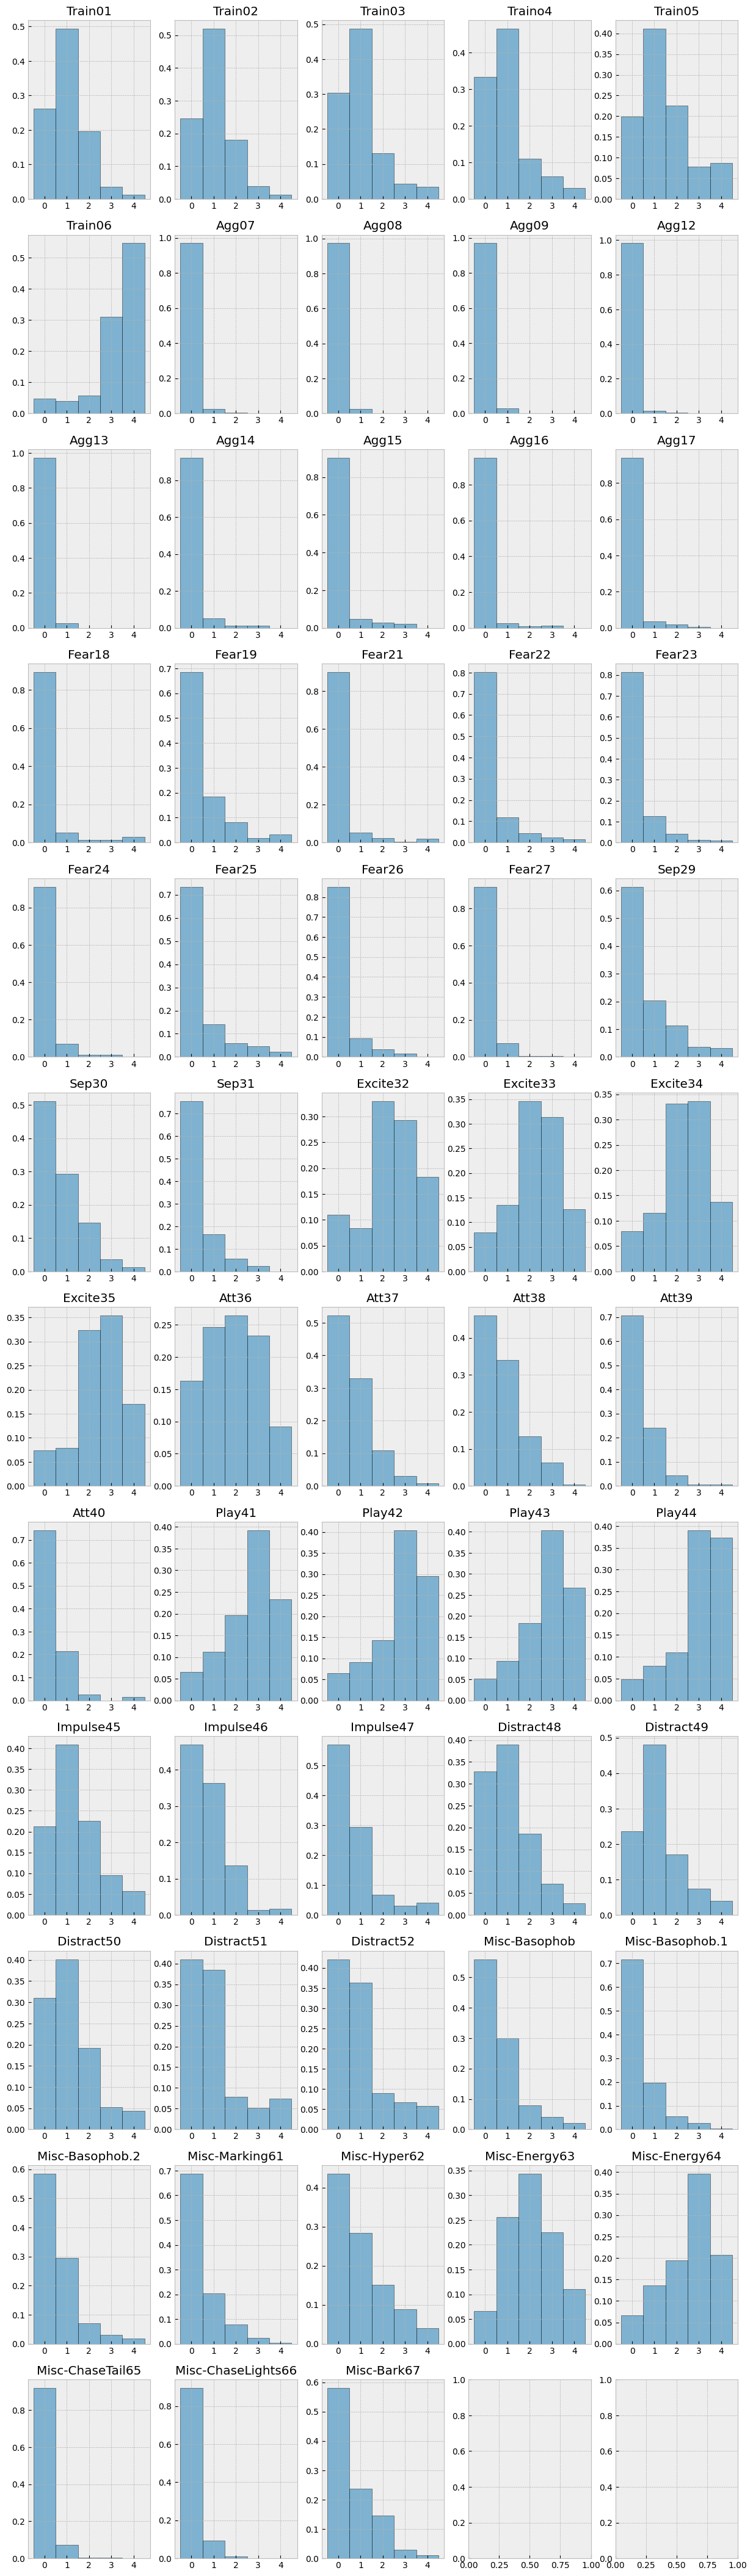

In [50]:
ax_idx = []
for i in np.arange(0,len(ctc_scores_sh),1):
    ax_idx.append("ax%s" % i)
    
fig, (ax_idx) = plt.subplots(nrows = int(np.ceil(len(ctc_scores_sh.columns)/5)),
                             ncols = 5,
                             figsize = (15,54))

histplots(ctc_scores_sh, ctc_scores_sh.columns, ax_idx)
fig.tight_layout

#### Form 375 (Post-QC)

<bound method Figure.tight_layout of <Figure size 1200x500 with 2 Axes>>

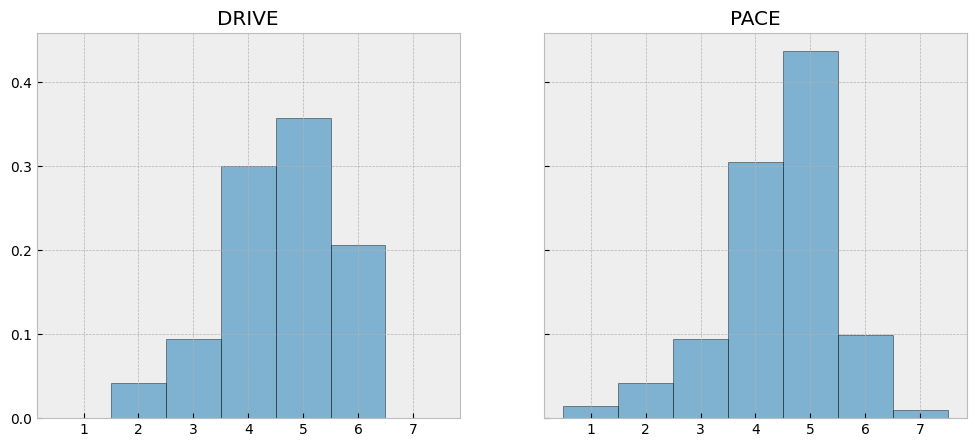

In [51]:
bins = [0.5 + i for i in range(8)]
fig, ax_idx = plt.subplots(1,2, figsize = (12, 5), sharey = True)
ax_idx[0].hist(f375_Qs_sh["DRIVE#"], 
               bins = bins, 
               density = True, 
               alpha = 0.6, 
               edgecolor = 'black')
ax_idx[1].hist(f375_Qs_sh["PACE#"], 
               bins = bins, 
               density = True, 
               alpha = 0.6, 
               edgecolor = 'black')
ax_idx[0].set_title("DRIVE")
ax_idx[1].set_title("PACE")
fig.tight_layout

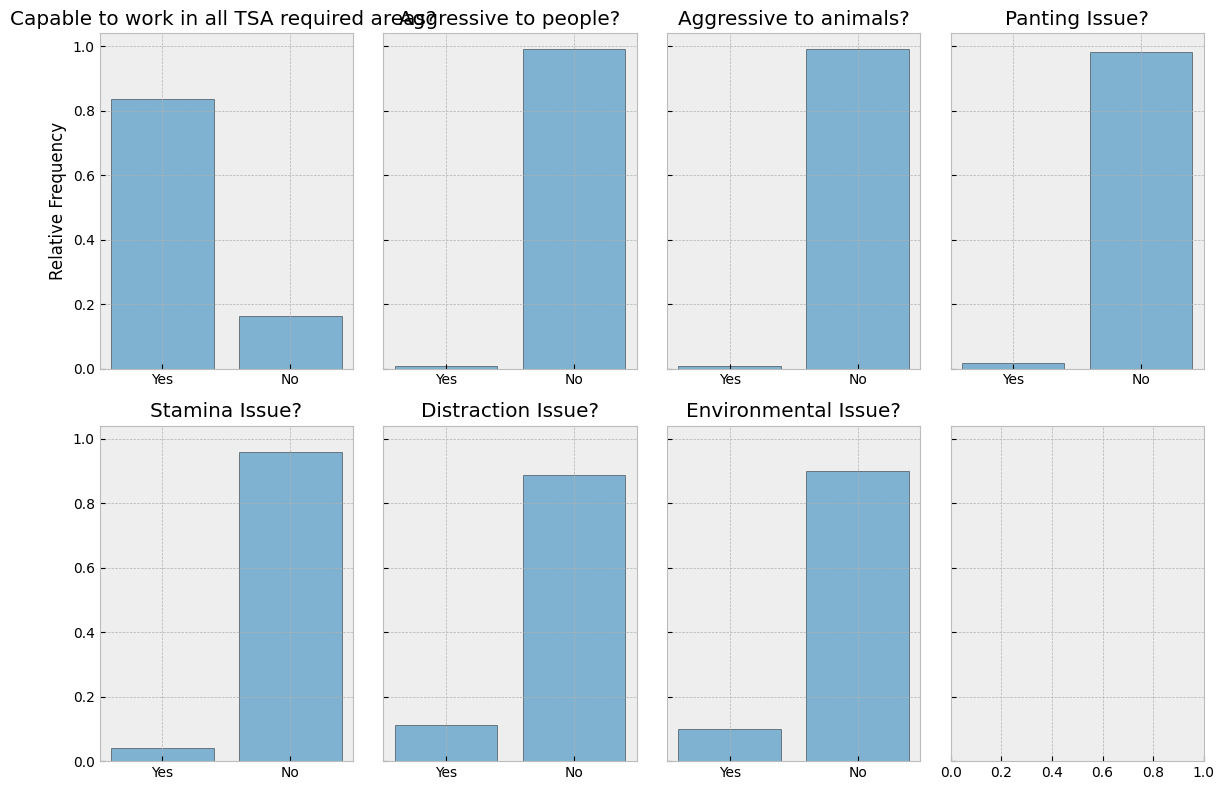

In [52]:
fig, ax_idx = plt.subplots(2,4, figsize = (12, 8), sharey = True)
ax_idx = ax_idx.flatten()
for i, col in enumerate(f375_Qs_sh.columns[0:7]):
    counts = f375_Qs_sh.iloc[:,i].value_counts(normalize = True)
    counts = counts[['Yes', 'No']]
    ax_idx[i].bar(counts.index, counts.values, alpha = 0.6, edgecolor = 'black')
    ax_idx[i].set_title(counts.index.name)
    if i == 0:
        ax_idx[i].set_ylabel('Relative Frequency')
fig.tight_layout()

____
### Joint Analysis (Form Questions)

In [53]:
header_list1    = ["Train", "Agg", "Fear", "Sep", "Excite", "Att", "Play", "Impulse", "Distract", "Misc", "Y/N Questions", "375 Scores"]
header_counts1  = ['Train']*6 + ['Agg']*9 + ['Fear']*9 + ['Sep']*3 + ['Excite']*4 + ['Att']*5 + ['Play']*4 + ['Impulse']*3 + ['Distract']*5 + ['Misc']*10 + ['Y/N Questions']*7 + ['375 Scores']*2

#### Multi-Dimensional Scaling (MDS)

In [54]:
mds            = MDS(n_components = 2,
                     max_iter = 300,
                     eps = 1e-3,
                     random_state = 101)
curr_mds       = mds.fit_transform(master_imp_T)

In [55]:
i              = 0
mds_X          = []
mds_Y          = []
while i < len(curr_mds):
    mds_X.append(curr_mds[i][0])
    mds_Y.append(curr_mds[i][1])
    i = i + 1

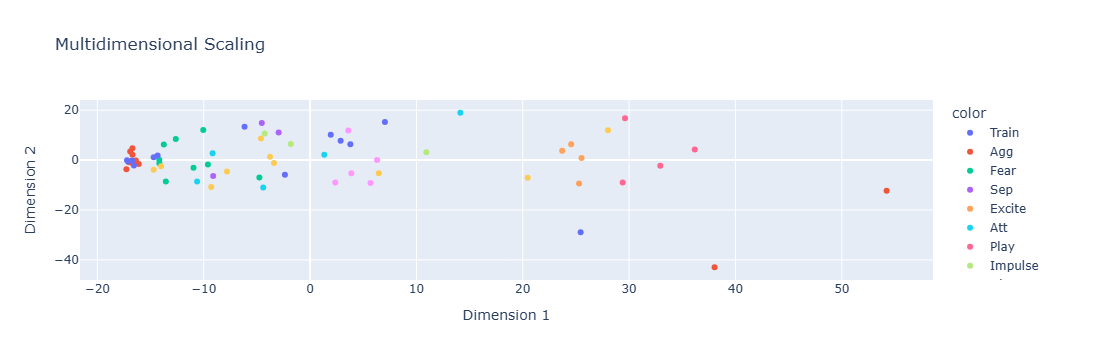

In [56]:
px.scatter(x = mds_X,
           y = mds_Y,
           color = header_counts1,
           hover_name = list(master_imp_T.index),
           title = "Multidimensional Scaling",
           labels = {"x": "Dimension 1", "y": "Dimension 2"})

#### Principal Component Analysis (PCA)

In [57]:
pca             = PCA(n_components = len(master_imp_T),
                      random_state = 101)
curr_pca        = pca.fit_transform(master_imp_T)

In [58]:
i   = 0
PC1 = []
PC2 = []
while i < len(curr_pca):
    PC1.append(curr_pca[i][0])
    PC2.append(curr_pca[i][1])
    i = i + 1

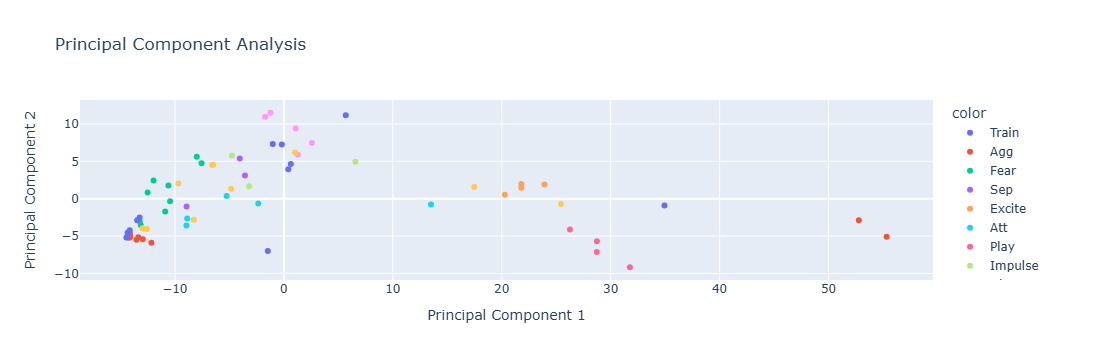

In [59]:
px.scatter(x = PC1,
           y = PC2,
           color = header_counts1,
           hover_name = list(master_imp_T.index),
           title = "Principal Component Analysis",
           labels = {"x": "Principal Component 1", "y": "Principal Component 2"})

#### t-distributed Stochastic Neighbor Embedding (t-SNE)

In [60]:
tsne           = TSNE(n_components = 2,
                      perplexity = 30,
                      early_exaggeration = 12,
                      learning_rate = 200,
                      max_iter = 2000,
                      n_iter_without_progress = 300,
                      min_grad_norm = 1e-7,
                      metric = 'euclidean',
                      init = 'random',
                      random_state = 101)
curr_tsne      = tsne.fit_transform(master_imp_T)

In [61]:
i              = 0
tsne_X         = []
tsne_Y         = []
while i < len(curr_tsne):
    tsne_X.append(curr_tsne[i][0])
    tsne_Y.append(curr_tsne[i][1])
    i = i + 1

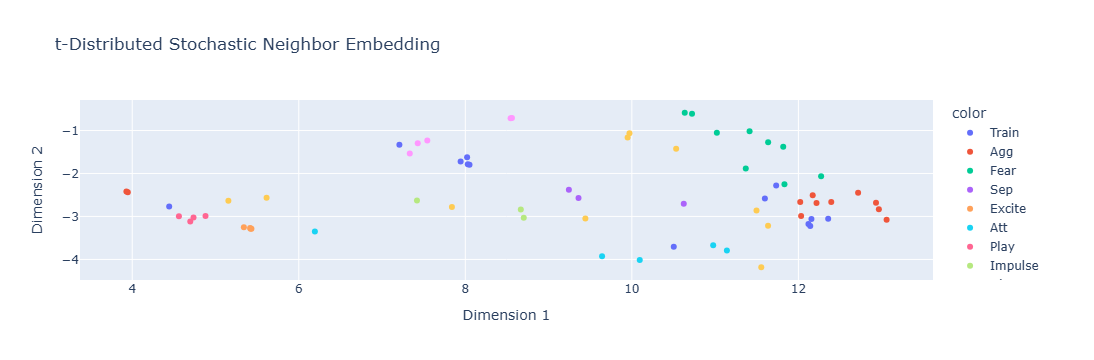

In [62]:
px.scatter(x = tsne_X,
           y = tsne_Y,
           color = header_counts1,
           hover_name = list(master_imp_T.index),
           title = "t-Distributed Stochastic Neighbor Embedding",
           labels = {"x": "Dimension 1", "y": "Dimension 2"})

____ 
#### Joint Analysis (Individual Dogs)

#### For now, this section will only display Success vs. Elimination for Behavioral Reasons for individual dogs. Eventually, this will feature a drop-down menu that will select specific questions for viewing.

In [63]:
header_counts2 = master_brands["Elimination Reason"] == "Behavioral"

#### Multi-Dimensional Scaling (MDS)

In [64]:
mds            = MDS(n_components = 2,
                     max_iter = 300,
                     eps = 1e-3,
                     random_state = 101)
curr_mds       = mds.fit_transform(master_imp)

In [65]:
i              = 0
mds_X          = []
mds_Y          = []
while i < len(curr_mds):
    mds_X.append(curr_mds[i][0])
    mds_Y.append(curr_mds[i][1])
    i = i + 1

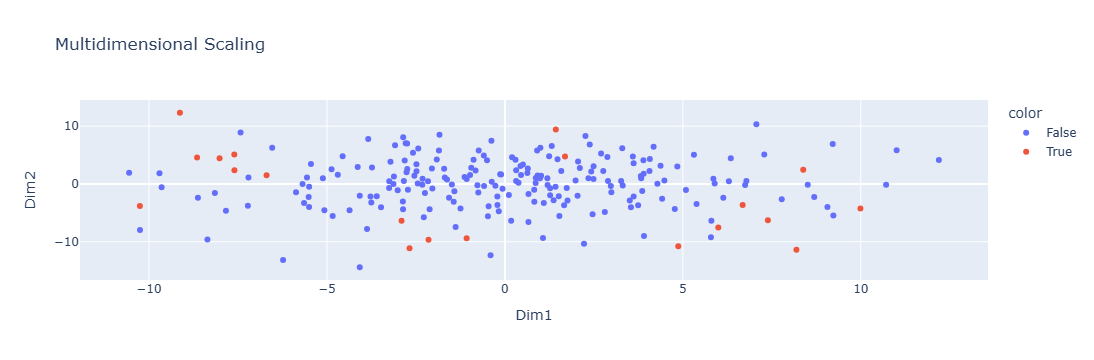

In [66]:
px.scatter(x = mds_X,
           y = mds_Y,
           color = header_counts2,
           hover_name = master_brands["UnivDogID"],
           title = "Multidimensional Scaling",
           labels = {"x": "Dim1", "y": "Dim2"})

#### Principal Component Analysis

In [67]:
pca             = PCA(n_components = len(master_imp.T),
                      random_state = 101)
curr_pca        = pca.fit_transform(master_imp)

In [68]:
# Setup the top two components for the PCA
i   = 0
PC1 = []
PC2 = []
while i < len(curr_pca):
    PC1.append(curr_pca[i][0])
    PC2.append(curr_pca[i][1])
    i = i + 1

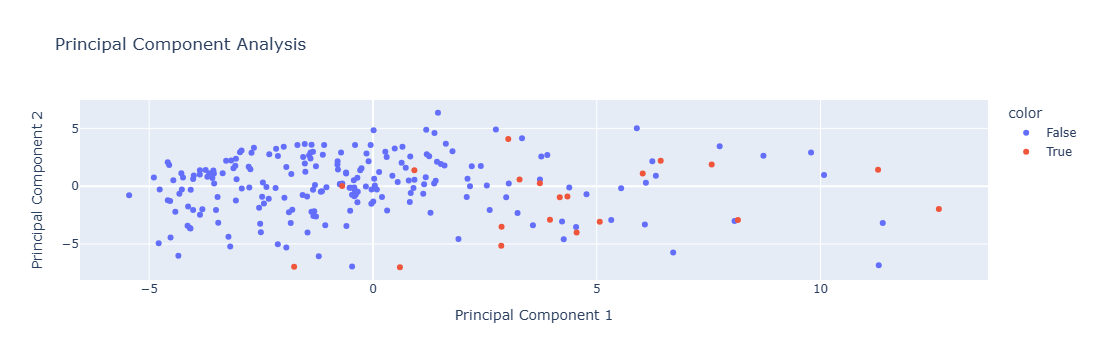

In [69]:
# Plot the top two components against eachother
px.scatter(x = PC1,
           y = PC2,
           color = header_counts2,
           hover_name = master_brands["UnivDogID"],
           title = "Principal Component Analysis",
           labels = {"x": "Principal Component 1", "y": "Principal Component 2"})

#### t-distributed Stochastic Neighbor Embedding (t-SNE)

In [70]:
tsne           = TSNE(n_components = 2,
                      perplexity = 30,
                      early_exaggeration = 12,
                      learning_rate = 200,
                      max_iter = 1000,
                      n_iter_without_progress = 300,
                      min_grad_norm = 1e-7,
                      metric = 'euclidean',
                      init = 'random',
                      random_state = 101)
curr_tsne      = tsne.fit_transform(master_imp)

In [71]:
i              = 0
tsne_X         = []
tsne_Y         = []
while i < len(curr_tsne):
    tsne_X.append(curr_tsne[i][0])
    tsne_Y.append(curr_tsne[i][1])
    i = i + 1

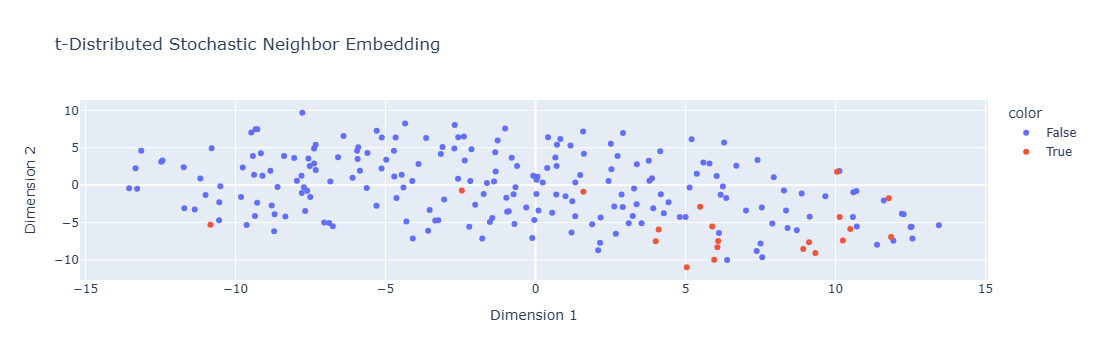

In [72]:
px.scatter(x = tsne_X,
           y = tsne_Y,
           color = header_counts2,
           hover_name = master_brands["UnivDogID"],
           title = "t-Distributed Stochastic Neighbor Embedding",
           labels = {"x": "Dimension 1", "y": "Dimension 2"})